In [36]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.bandwidths import bw_silverman

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter
import rpy2.rlike.container as rlc

np_cv_rules = default_converter + numpy2ri.converter

In [6]:
base = importr('base')
copula = importr('copula')
MASS = importr('MASS')
fGarch = importr('fGarch')

In [9]:
import sys
sys.path.append('../')  # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [47]:
from sdafe.r import tl, sv
from ch08.utils import fit_copula, plot_empirical_copula, plot_copula

### 8.9.1 Simulating from Copula Models

#### Problem 1

Sample from a t-copula with correlations $(-0.6, 0.75, 0.0)$. The sample size is 500.

In [11]:
base.set_seed(5640)
with np_cv_rules.context():
    cop_t_dim3 = copula.tCopula(dim=3, param=robjects.FloatVector([-0.6, 0.75, 0]), dispstr='un', df=1)
    rand_t_cop = copula.rCopula(n=500, copula=cop_t_dim3)

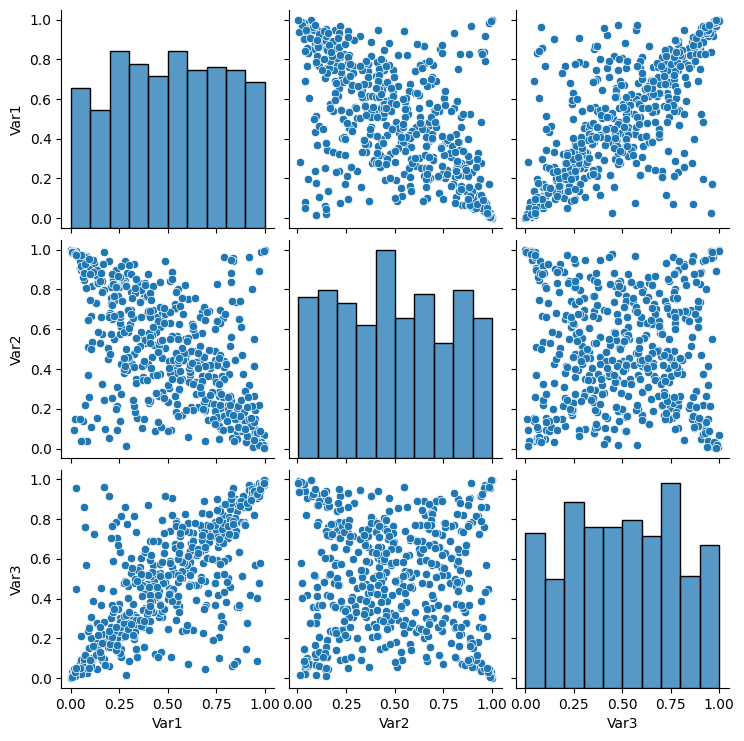

In [12]:
sns.pairplot(pd.DataFrame(rand_t_cop, columns=['Var1', 'Var2', 'Var3']));

In [13]:
np.corrcoef(rand_t_cop.T)

array([[ 1.        , -0.54999514,  0.70707296],
       [-0.54999514,  1.        , -0.06538499],
       [ 0.70707296, -0.06538499,  1.        ]])

#### Problem 2

(a) Components 2 and 3 are uncorrelated, but exhibit tail dependency (extreme values tend to happen together).

(b) Tail dependence is observed in each pair of variables.

(c) Tail dependence presents itself as congregation of points in the corners of plots.

(d) The effect of tail dependence is also to reduce the absolute value of the correlation in the generated sample

In [14]:
res = stats.pearsonr(rand_t_cop[:, 0], rand_t_cop[:, 1])
res.confidence_interval()

ConfidenceInterval(low=-0.6083455852996499, high=-0.4857310670971323)

In [15]:
res = stats.pearsonr(rand_t_cop[:, 0], rand_t_cop[:, 2])
res.confidence_interval()

ConfidenceInterval(low=0.6603249272243842, high=0.7483623580414523)

#### Problem 3

In [16]:
base.set_seed(5640)

rates = np.array([2, 3, 4])

cop_normal_dim3 = copula.normalCopula(dim=3, param=robjects.FloatVector([-0.6, 0.75, 0.0]), dispstr='un')
mvdc_normal = copula.mvdc(copula=cop_normal_dim3, margins=sv('exp', 'exp', 'exp'), paramMargins=tl([{'rate': float(r)} for r in rates]))

with np_cv_rules.context():
    rand_mvdc = copula.rMvdc(n=1000, mvdc=mvdc_normal)

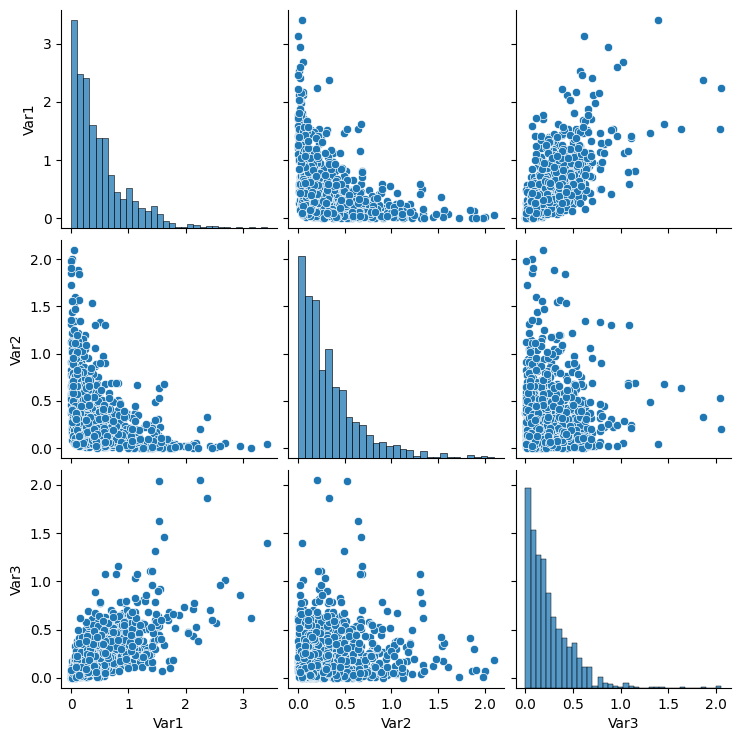

In [17]:
sns.pairplot(pd.DataFrame(rand_mvdc, columns=['Var1', 'Var2', 'Var3']));

In [19]:
def plot_density(ax, x, xlim=None, npoints=200):
    kde = KernelDensity(bandwidth=bw_silverman(x), kernel='gaussian').fit(x.reshape(-1, 1))

    if xlim is None:
        xs = np.linspace(np.min(x), np.max(x), npoints)
    else:
        xs = np.linspace(xlim[0], xlim[1], npoints)
    vals = kde.score_samples(xs.reshape(-1, 1))

    ax.plot(xs, np.exp(vals))

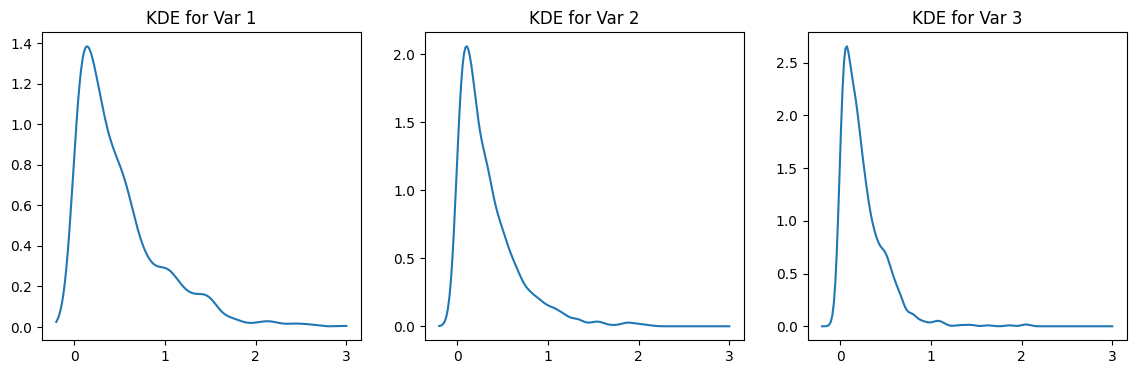

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

for i in range(3):
    plot_density(axs[i], rand_mvdc[:, i], xlim=(-0.2, 3.0))
    axs[i].set_title(f'KDE for Var {i+1}')

(a) The margial distributions are exponential with expected values equal to the reciprocals of the rates:

In [21]:
np.mean(rand_mvdc, axis=0)

array([0.49920601, 0.33579755, 0.24790078])

In [22]:
1 / rates

array([0.5       , 0.33333333, 0.25      ])

(b) The second and third components are independent, since for a normal copula, dependece arises through correlation only and the correlation between those components is 0 by construction.

### 8.9.2 Fitting Copula Models to Bivariate Return Data

In [23]:
net_rtns = pd.read_csv('../data/IBM_SP500_04_14_daily_netRtns.csv', index_col=0, parse_dates=[0])
net_rtns.head()

,IBM,SP500
Date,,
2004-06-02,-0.147473,0.338031
2004-06-03,-0.725027,-0.742229
2004-06-04,0.243441,0.524789
2004-06-07,1.227739,1.596437
2004-06-08,1.586032,0.154329


In [24]:
ibm = net_rtns['IBM'].values
sp500 = net_rtns['SP500'].values

In [25]:
with np_cv_rules.context():
    est_ibm = MASS.fitdistr(ibm, 't')['estimate']
    est_sp500 = MASS.fitdistr(sp500, 't')['estimate']

In [26]:
def adjust_sigma(sigma, nu):
    return sigma * np.sqrt(nu / (nu - 2))

In [27]:
est_ibm[1] = adjust_sigma(est_ibm[1], est_ibm[2])
est_sp500[1] = adjust_sigma(est_sp500[1], est_sp500[2])

#### Problem 4

In [28]:
cor_tau = stats.kendalltau(ibm, sp500).statistic
omega = np.sin(cor_tau * math.pi / 2)
omega

0.701834567127758

In [29]:
cop_t_dim2 = copula.tCopula(float(omega), dim=2, dispstr='un', df=4)

In [30]:
data1 = np.vstack([
    stats.t.cdf(ibm, loc=est_ibm[0], scale=est_ibm[1] * np.sqrt((est_ibm[2] - 2) / est_ibm[2]), df=est_ibm[2]),
    stats.t.cdf(sp500, loc=est_sp500[0], scale=est_sp500[1] * np.sqrt((est_sp500[2] - 2) / est_sp500[2]), df=est_sp500[2]),
]).T

In [31]:
def rank(a, axis=0):
    """Rank values in an array along a given axis"""
    shape1d = tuple(d if i == axis else 1 for i, d in enumerate(a.shape))
    vals = np.broadcast_to(np.arange(a.shape[axis]).reshape(shape1d), a.shape)
    t = np.zeros(a.shape)
    np.put_along_axis(t, np.argsort(a, axis=axis), vals, axis=axis)
    return t  

In [32]:
data2 = (rank(data1, axis=0) + 1) / (data1.shape[0] + 1)

In [33]:
with np_cv_rules.context():
    ft1 = copula.fitCopula(cop_t_dim2, data1, method='ml', start=robjects.FloatVector([omega, 4]))
    est1 = ft1.slots['estimate']
    ft2 = copula.fitCopula(cop_t_dim2, data2, method='ml', start=robjects.FloatVector([omega, 4]))
    est2 = ft2.slots['estimate']

In [34]:
est1

array([0.70217192, 2.9834079 ])

In [35]:
est2

array([0.70313529, 3.0220767 ])

(a) The first method uses the uniform-transformed values, the second method uses the ranks of values.

(b) The estimates are the same for practical purposes.

#### Problem 6

In [37]:
mvdc_t_t = copula.mvdc(cop_t_dim2, sv('std', 'std'), tl([
    {'mean': est_ibm[0], 'sd': est_ibm[1], 'nu': est_ibm[2]},
    {'mean': est_sp500[0], 'sd': est_sp500[1], 'nu': est_sp500[2]},
]))

NB: issues when constructing an R object like `mvdc` are not reported above. For example, there was an issue due to the `fGarch` package not being imported. No issue was reported creating the `mvdc_t_t` object, but attempting the optimisation below reported an issue converging. To diagnose, I had to attempt generating random variates from `mvdc_t_t`, which reported the error.

In [38]:
data0 = np.vstack([ibm, sp500]).T

In [39]:
def obj_fn(param):
    with np_cv_rules.context():
        return -copula.loglikMvdc(param, data0, mvdc_t_t)

In [40]:
start = np.concatenate([est_ibm, est_sp500, est1])
lower = np.array([-0.1, 0.001, 2.2, -0.1, 0.001, 2.2, 0.2, 2.5])
upper = np.array([0.1, 10, 15, 0.1, 10, 15, 0.9, 15])

In [41]:
%time fit = minimize(obj_fn, start, method='L-BFGS-B', bounds=list(zip(lower, upper)))
fit

CPU times: user 22.9 s, sys: 23.4 s, total: 46.3 s
Wall time: 11.9 s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6828.21882405242
        x: [ 6.505e-02  1.379e+00  3.360e+00  7.425e-02  1.801e+00
             2.337e+00  7.042e-01  2.973e+00]
      nit: 36
      jac: [-2.295e-01 -1.446e-02 -2.146e-02  1.914e-01  2.665e-02
             8.413e-02 -2.522e-01  5.821e-03]
     nfev: 360
     njev: 40
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

(a) The estimates of the copula parameters are:

In [42]:
fit.x[-2:]

array([0.70416913, 2.97300038])

(b) The estimates of the parameters of the marginal distributions are:

In [43]:
fit.x[:-2].reshape(2, 3)

array([[0.06504747, 1.37918877, 3.35975733],
       [0.0742503 , 1.8005291 , 2.3374762 ]])

(c) The maximum likelihood method was used, as it optimised simultaneously the parameters of the marginal distributions and those of the copula.

(d) The coefficient of lower-tail dependence can be estimated using (8.21)

In [44]:
rho = fit.x[-2]
nu = fit.x[-1]
2 * stats.t.cdf(-np.sqrt((nu + 1) * (1 - rho) / (1 + rho)), df=nu + 1)

0.4532618721211326

In [45]:
def estimate_lower_tail_dep(cop, tol=1e-5, maxiter=30):
    """Estimate the lower tail dependency coefficient from its definition as a limit"""
    q = 0.5
    with np_cv_rules.context():
        l0 = (copula.pCopula(np.vstack([[q, q]]), copula=cop) / q)[0]
        for i in range(maxiter):
            q /= 10
            l = (copula.pCopula(np.vstack([[q, q]]), copula=cop) / q)[0]
            if np.abs(l - l0) < tol:
                return l
            l0 = l
    raise ValueError(f'Could not find the value within {maxiter} iterations (last value: {l}, error: {l - l0})')

In [46]:
estimate_lower_tail_dep(copula.tCopula(float(fit.x[6]), dim=2, dispstr='un', df=float(np.round(fit.x[7]))))

0.4515483679459405

#### Problem 7

In [48]:
C_norm = fit_copula(copula.normalCopula(dim=2), None, data1)
C_norm

(array([0.69638032]), -1666.6479173105156)

In [49]:
with np_cv_rules.context():
    res = copula.loglikCopula(robjects.FloatVector(C_norm[0]), u=data1, copula=copula.normalCopula(dim=2))
-2 * res + 2 * 1

array([-1666.64791731])

In [50]:
C_frank = fit_copula(copula.frankCopula(3, dim=2), None, data1)
C_frank

(array([5.77302771]), -1562.3829724815132)

In [51]:
C_clayton = fit_copula(copula.claytonCopula(1, dim=2), None, data1)
C_clayton

(array([1.96252137]), -1331.4866530894906)

In [52]:
C_gumbel = fit_copula(copula.gumbelCopula(3, dim=2), None, data1)
C_gumbel

(array([1.97007319]), -1735.932457878003)

In [53]:
C_joe = fit_copula(copula.joeCopula(2, dim=2), None, data1)
C_joe

(array([2.27087141]), -1379.8215970488902)

In [54]:
n = 200 # data1.shape[0]
xs = (np.arange(1, n + 1) / (n + 1))
grid = np.vstack([np.repeat(xs, n), np.tile(xs, n)]).T

In [55]:
# calculate the empirical copula
with np_cv_rules.context():
    Cn = copula.C_n(u=grid, X=data1)
    zs = Cn.reshape(n, n).T

In [56]:
levels = np.arange(1, 10) / 10

In [57]:
def plot_copula_comparison(ax, copula_def, title):
    plot_empirical_copula(ax, xs, xs, zs, levels)
    plot_copula(ax, copula_def, xs, levels, copula.pCopula);
    ax.set_title(title);

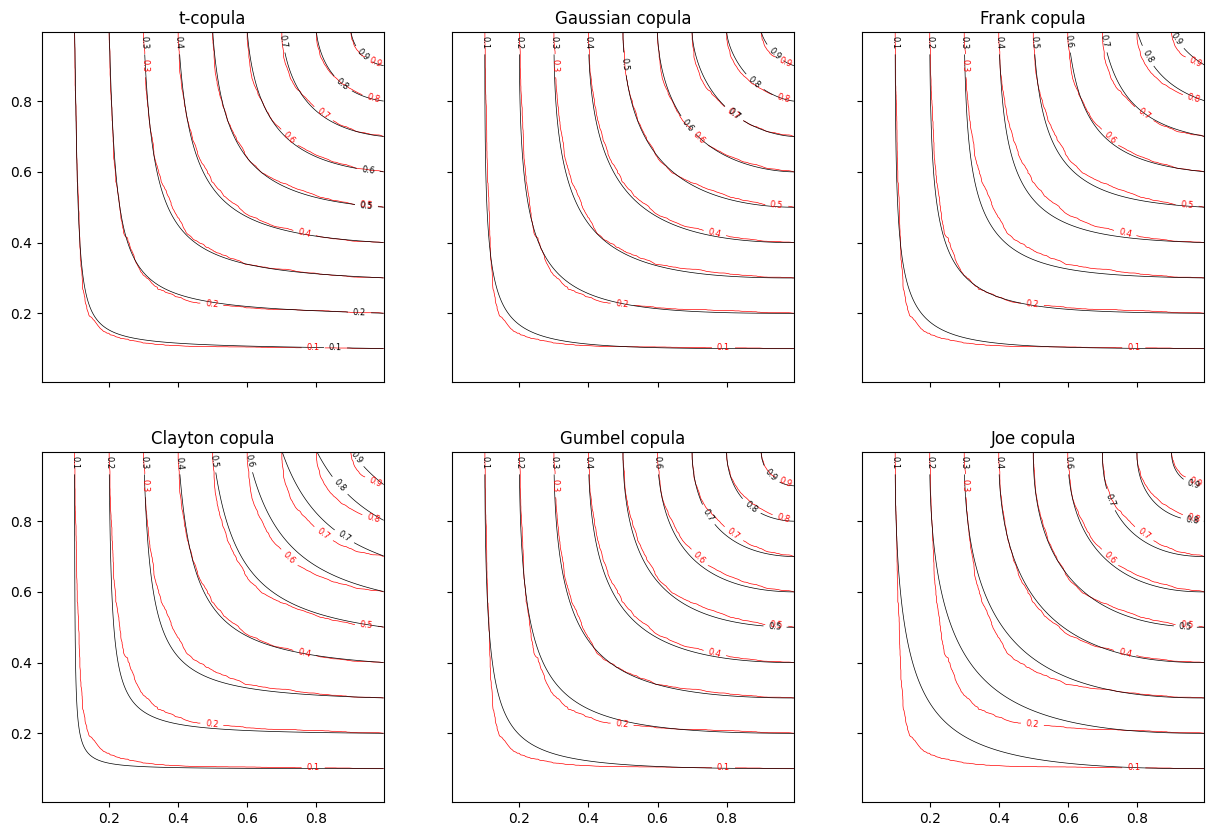

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

plot_copula_comparison(
    axs[0][0],
    copula.tCopula(float(fit.x[6]), dim=2, df=float(np.round(fit.x[7]))),
    't-copula',
)

plot_copula_comparison(
    axs[0][1],
    copula.normalCopula(float(C_norm[0][0]), dim=2),
    'Gaussian copula',
)

plot_copula_comparison(
    axs[0][2],
    copula.frankCopula(float(C_frank[0][0]), dim=2),
    'Frank copula',
)

plot_copula_comparison(
    axs[1][0],
    copula.claytonCopula(float(C_clayton[0][0]), dim=2),
    'Clayton copula',
)

plot_copula_comparison(
    axs[1][1],
    copula.gumbelCopula(float(C_gumbel[0][0]), dim=2),
    'Gumbel copula',
)

plot_copula_comparison(
    axs[1][2],
    copula.joeCopula(float(C_joe[0][0]), dim=2),
    'Joe copula',
)

The t-copula provides the best fit to the empirical data.

#### Problem 8

In [59]:
n = 500 # data1.shape[0]
xs = (np.arange(1, n + 1) / (n + 1))
grid = np.vstack([np.repeat(xs, n), np.tile(xs, n)]).T

In [60]:
with np_cv_rules.context():
    emp_pdf = MASS.kde2d(data1[:, 0], data1[:, 1])

In [61]:
levels = np.arange(1, 15) / 5

In [62]:
def plot_copula_pdf_comparison(ax, copula_def, title):
    plot_empirical_copula(ax, emp_pdf['x'], emp_pdf['y'], emp_pdf['z'].T, levels)
    plot_copula(ax, copula_def, xs, levels, copula.dCopula);
    ax.set_title(title);

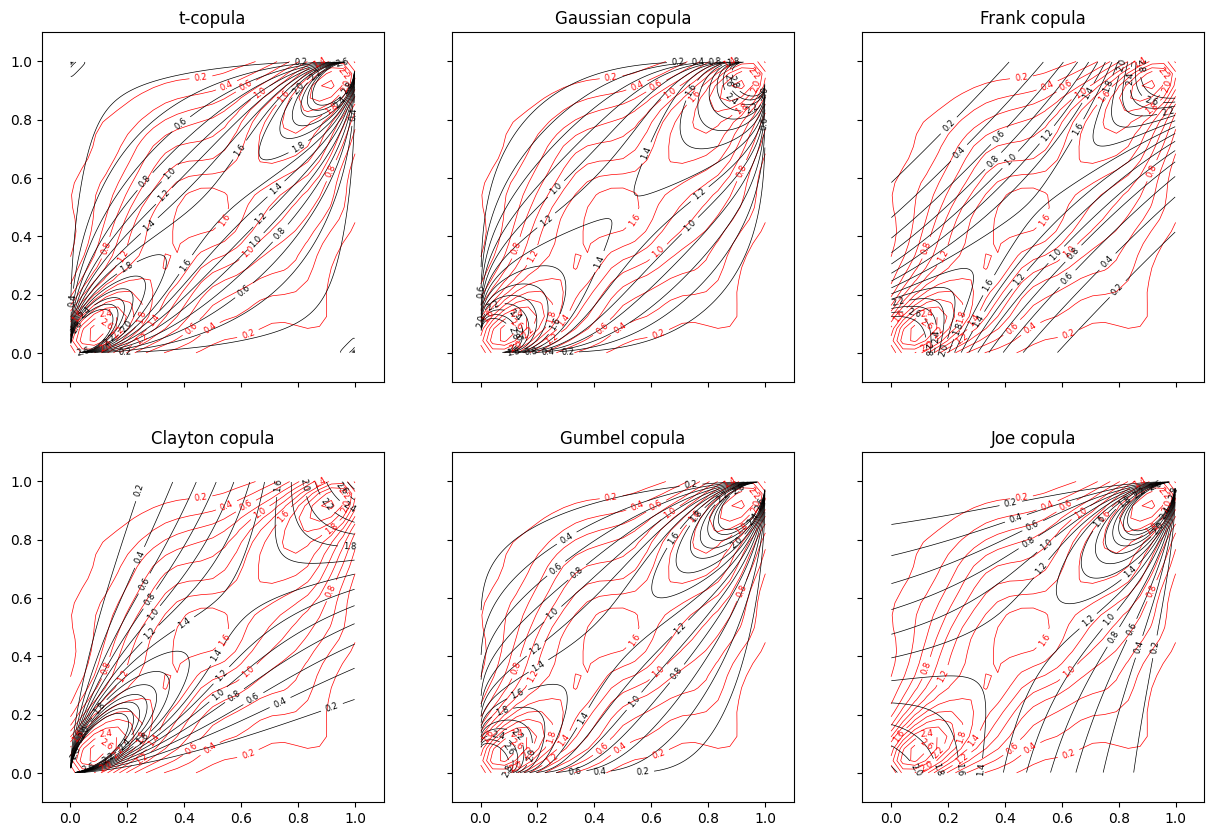

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

axs[0][0].set_xlim([-0.1, 1.1])
axs[0][0].set_ylim([-0.1, 1.1])

plot_copula_pdf_comparison(
    axs[0][0],
    copula.tCopula(float(fit.x[6]), dim=2, df=float(np.round(fit.x[7]))),
    't-copula',
)

plot_copula_pdf_comparison(
    axs[0][1],
    copula.normalCopula(float(C_norm[0][0]), dim=2),
    'Gaussian copula',
)

plot_copula_pdf_comparison(
    axs[0][2],
    copula.frankCopula(float(C_frank[0][0]), dim=2),
    'Frank copula',
)

plot_copula_pdf_comparison(
    axs[1][0],
    copula.claytonCopula(float(C_clayton[0][0]), dim=2),
    'Clayton copula',
)

plot_copula_pdf_comparison(
    axs[1][1],
    copula.gumbelCopula(float(C_gumbel[0][0]), dim=2),
    'Gumbel copula',
)

plot_copula_pdf_comparison(
    axs[1][2],
    copula.joeCopula(float(C_joe[0][0]), dim=2),
    'Joe copula',
)

The normal copula seem to be closest to the empirical values visually, although it is quite difficult to judge from these plots.

#### Problem 9

The AIC values for all copulas except the t-copula were calculated in Problem 7. For the t-copula:

In [64]:
-2 * obj_fn(fit.x) + 2 * len(fit.x)

array([-13640.4376481])

Based on the AIC values, the t-copula provides the best fit.